# Transfer Learning in PyTorch

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

/Users/ryantenbarge/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define the mean and standard deviation of this image dataset for normalization purposes.

In [3]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

Define image transformations

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

Define Image Directory Name

In [5]:
data_dir = '../data/hymenoptera'
sets = ['train', 'val']

Create image datasets and dataloaders

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in sets}

In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True)
               for x in sets}

In [8]:
dataset_sizes = {x: len(image_datasets[x]) for x in sets}
dataset_sizes

{'train': 244, 'val': 153}

In [9]:
class_names = image_datasets['train'].classes
class_names

['ants', 'bees']

In [24]:
classes = {0:'ant', 1:'bee'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image of class: ant')

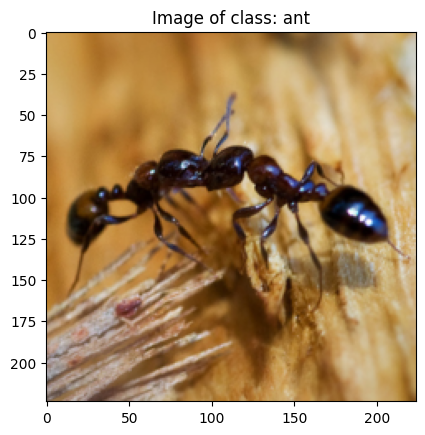

In [32]:
images, labels = next(iter(dataloaders['train']))
image = images[0].numpy().transpose((1, 2, 0))
image = (image * std) + mean
plt.imshow(image)
plt.title(f'Image of class: {classes[labels[0].item()]}')

In [67]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # each epoch has a training and validation phase
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        print('-'*10)

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to validation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #forward
                #track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimizer iff in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}, {phase} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model


Load the pre-trained model from Torchvision

In [68]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

Freeze all model parameters so they are not re-optimized.

In [69]:
for param in model.parameters(): # freeze all the model parameters
    param.requires_grad = False

In [75]:
# Check how many features are input to the final linear layer of the model
num_features = model.fc.in_features
num_features

512

Redefine the final layer. The requires_grad attribute will be automatically set to True.

In [71]:
model.fc = nn.Linear(in_features=num_features, out_features=2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

The learning rate scheduler will decrease the learning rate as the epoch number increases.

In [73]:
exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)

In [74]:
model = train_model(model=model, criterion=criterion, optimizer=optimizer,
                    scheduler=exp_lr_scheduler, num_epochs=10)

Epoch: 1/10
----------
train Loss: 0.8213, train Acc: 0.6393
val Loss: 0.3847, val Acc: 0.8366
Epoch: 2/10
----------
train Loss: 0.6233, train Acc: 0.7541
val Loss: 0.1858, val Acc: 0.9542
Epoch: 3/10
----------
train Loss: 0.5391, train Acc: 0.7500
val Loss: 0.3197, val Acc: 0.8758
Epoch: 4/10
----------
train Loss: 0.4079, train Acc: 0.8115
val Loss: 0.1728, val Acc: 0.9542
Epoch: 5/10
----------
train Loss: 0.4163, train Acc: 0.8033
val Loss: 0.1508, val Acc: 0.9542
Epoch: 6/10
----------
train Loss: 0.3357, train Acc: 0.8811
val Loss: 0.1590, val Acc: 0.9542
Epoch: 7/10
----------
train Loss: 0.4527, train Acc: 0.7910
val Loss: 0.2036, val Acc: 0.9150
Epoch: 8/10
----------
train Loss: 0.4088, train Acc: 0.8279
val Loss: 0.1658, val Acc: 0.9542
Epoch: 9/10
----------
train Loss: 0.3293, train Acc: 0.8484
val Loss: 0.1778, val Acc: 0.9477
Epoch: 10/10
----------
train Loss: 0.3723, train Acc: 0.8238
val Loss: 0.1603, val Acc: 0.9477
Training complete in 1m 40s
Best val Acc: 0.95424

It looks like this model was able to achieve over 90% accuracy with the validation data after only 10 epochs.